In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import math
import numpy as np
from collections import Counter

# Kiểm tra thiết bị (GPU hay CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Đang sử dụng thiết bị: {device}")

Đang sử dụng thiết bị: cuda


Đang tiến hành đọc dữ liệu (Chế độ JSON Lines)...
Train: Đã đọc 5027 câu.
Dev: Đã đọc 2000 câu.
Test: Đã đọc 3000 câu.

KẾT QUẢ PHÂN TÍCH ĐỘ DÀI (PhoNER-COVID19)
Tổng số câu: 10027
Min length: 7
Max length: 186
Mean length: 34.63
Median length: 31.0
--------------------
Top 90% câu ngắn hơn: 56 tokens
Top 95% câu ngắn hơn: 66 tokens
Top 99% câu ngắn hơn: 88 tokens


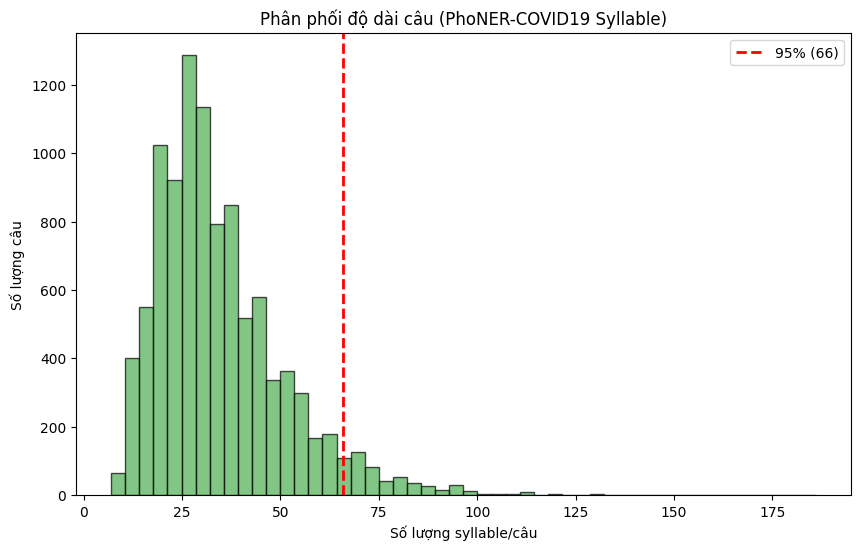

In [7]:
import matplotlib.pyplot as plt
import os

# --- CẤU HÌNH ĐƯỜNG DẪN ---
base_path = '/content/drive/MyDrive/PhoNER_COVID19/data/syllable'

files = {
    'Train': os.path.join(base_path, 'train_syllable.json'),
    'Dev':   os.path.join(base_path, 'dev_syllable.json'),
    'Test':  os.path.join(base_path, 'test_syllable.json')
}

all_lengths = []

print("Đang tiến hành đọc dữ liệu (Chế độ JSON Lines)...")

for name, path in files.items():
    lengths = []
    try:
        with open(path, 'r', encoding='utf-8') as f:

            for line in f:
                line = line.strip()
                if not line: continue  # Bỏ qua dòng trống nếu có

                try:
                    item = json.loads(line) # Parse JSON của từng dòng

                    # Lấy list words
                    words = item.get('words', [])

                    # Đếm số lượng từ
                    n_tokens = len(words)
                    if n_tokens > 0:
                        lengths.append(n_tokens)

                except json.JSONDecodeError:
                    continue # Bỏ qua nếu có dòng lỗi

        print(f"{name}: Đã đọc {len(lengths)} câu.")
        all_lengths.extend(lengths)

    except FileNotFoundError:
        print(f"{name}: Không tìm thấy file tại {path}")
    except Exception as e:
        print(f"{name}: Lỗi không xác định ({str(e)})")

# --- Thống kê và Vẽ biểu đồ ---
all_lengths = np.array(all_lengths)

if len(all_lengths) > 0:
    print("\n" + "="*40)
    print("KẾT QUẢ PHÂN TÍCH ĐỘ DÀI (PhoNER-COVID19)")
    print("="*40)
    print(f"Tổng số câu: {len(all_lengths)}")
    print(f"Min length: {np.min(all_lengths)}")
    print(f"Max length: {np.max(all_lengths)}")
    print(f"Mean length: {np.mean(all_lengths):.2f}")
    print(f"Median length: {np.median(all_lengths)}")

    # Các mốc phần trăm
    p90 = np.percentile(all_lengths, 90)
    p95 = np.percentile(all_lengths, 95)
    p99 = np.percentile(all_lengths, 99)

    print("-" * 20)
    print(f"Top 90% câu ngắn hơn: {int(p90)} tokens")
    print(f"Top 95% câu ngắn hơn: {int(p95)} tokens")
    print(f"Top 99% câu ngắn hơn: {int(p99)} tokens")
    print("="*40)

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    plt.hist(all_lengths, bins=50, color='#4CAF50', edgecolor='black', alpha=0.7)
    plt.axvline(p95, color='red', linestyle='dashed', linewidth=2, label=f'95% ({int(p95)})')
    plt.title('Phân phối độ dài câu (PhoNER-COVID19 Syllable)')
    plt.xlabel('Số lượng syllable/câu')
    plt.ylabel('Số lượng câu')
    plt.legend()
    plt.show()
else:
    print("Không có dữ liệu để phân tích.")

=> Chọn max_len là 100

In [8]:
BASE_DATA_PATH = '/content/drive/MyDrive/PhoNER_COVID19/data/syllable'

config = {
    # --- 1. Data Paths (CẬP NHẬT MỚI) ---

    'train_path': os.path.join(BASE_DATA_PATH, 'train_syllable.json'),
    'val_path':   os.path.join(BASE_DATA_PATH, 'dev_syllable.json'),
    'test_path':  os.path.join(BASE_DATA_PATH, 'test_syllable.json'),

    # --- 2. Paper Hyperparameters [Attention Is All You Need] ---
    'd_model': 512,
    'n_head': 8,
    'n_layers': 3,       # Giữ nguyên theo yêu cầu đề bài
    'd_ff': 2048,
    'dropout': 0.1,
    'label_smoothing': 0.1,

    # --- 3. Training Config ---
    'max_len': 200,
    'batch_size': 32,

    'warmup_steps': 2000,

    'epochs': 100
}

print("Cấu hình đã được cập nhật:")
print(f"- Max Length: {config['max_len']}")
print(f"- Train path: {config['train_path']}")

Cấu hình đã được cập nhật:
- Max Length: 200
- Train path: /content/drive/MyDrive/PhoNER_COVID19/data/syllable/train_syllable.json


In [9]:
class PhoNERDataset(Dataset):
    def __init__(self, json_path, vocab=None, tag_map=None, max_len=200, is_train=True):
        self.data = []
        self.hard_limit = max_len

        # Tập hợp tất cả các tag để xây dựng từ điển nhãn (chỉ dùng khi train)
        collected_tags = set()
        all_tokens = []

        print(f"Đang đọc file: {json_path}")

        # 1. Đọc file theo dạng JSON Lines (Từng dòng một)
        with open(json_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line: continue
                try:
                    item = json.loads(line)
                    # PhoNER: key là 'words' và 'tags'
                    words = item.get('words', [])
                    tags = item.get('tags', [])

                    # Kiểm tra dữ liệu hợp lệ: Số từ phải bằng số nhãn
                    if len(words) > 0 and len(words) == len(tags):
                        self.data.append((words, tags))
                        if is_train:
                            all_tokens.extend([w.lower() for w in words])
                            collected_tags.update(tags)
                except json.JSONDecodeError:
                    continue

        # 2. Xây dựng Vocabulary (Chỉ làm ở tập Train)
        if is_train:
            # Xây dựng Vocab cho TỪ (Word Vocabulary)
            word_counts = Counter(all_tokens)
            # <PAD>=0, <UNK>=1. Chỉ lấy từ xuất hiện >= 2 lần để giảm nhiễu
            sorted_tokens = [w for w, c in word_counts.items() if c >= 2]
            self.vocab = {w: i+2 for i, w in enumerate(sorted_tokens)}
            self.vocab['<PAD>'] = 0
            self.vocab['<UNK>'] = 1

            # Xây dựng Map cho NHÃN (Tag Map) - QUAN TRỌNG CHO NER
            # Sắp xếp để đảm bảo thứ tự nhất quán: O, B-LOC, I-LOC...
            self.tag_map = {t: i for i, t in enumerate(sorted(list(collected_tags)))}
            self.num_tags = len(self.tag_map)

            print(f"-> Đã xây dựng Vocab: {len(self.vocab)} từ.")
            print(f"-> Đã xây dựng Tag Map: {self.num_tags} nhãn ({self.tag_map})")

        else:
            # Dev/Test bắt buộc phải dùng vocab và tag_map của tập Train
            assert vocab is not None and tag_map is not None, "Phải cung cấp vocab và tag_map cho tập Dev/Test"
            self.vocab = vocab
            self.tag_map = tag_map
            self.num_tags = len(tag_map)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words, tags = self.data[idx]

        # Chuyển đổi dữ liệu thành ID
        # Xử lý Words: Chuyển thành ID, dùng <UNK> nếu từ lạ
        word_ids = [self.vocab.get(w.lower(), self.vocab['<UNK>']) for w in words]

        # Xử lý Tags: Chuyển thành ID.
        # Lưu ý: Nếu tag lạ (hiếm gặp), ta gán về 0 (thường là 'O' - Outside) để an toàn
        # Nhưng tốt nhất là tag_map nên bao phủ hết.
        tag_ids = [self.tag_map.get(t, 0) for t in tags]

        # 4. Truncate (Cắt bớt) nếu dài quá hard_limit
        if len(word_ids) > self.hard_limit:
            word_ids = word_ids[:self.hard_limit]
            tag_ids = tag_ids[:self.hard_limit]

        # Trả về Tensor (chưa pad, việc pad sẽ làm ở hàm collate_fn)
        return torch.tensor(word_ids, dtype=torch.long), torch.tensor(tag_ids, dtype=torch.long)


# 1. Load tập Train trước để có vocab và tag_map
train_dataset = PhoNERDataset(config['train_path'], max_len=config['max_len'], is_train=True)

# Lấy vocab và tag_map từ train để truyền cho Dev/Test
vocab = train_dataset.vocab
tag_map = train_dataset.tag_map

# 2. Load Dev và Test
val_dataset = PhoNERDataset(config['val_path'], vocab=vocab, tag_map=tag_map, max_len=config['max_len'], is_train=False)
test_dataset = PhoNERDataset(config['test_path'], vocab=vocab, tag_map=tag_map, max_len=config['max_len'], is_train=False)

print(f"\nSố lượng mẫu train: {len(train_dataset)}")
print(f"Số lượng mẫu val: {len(val_dataset)}")
print(f"Ví dụ Tag Map: {tag_map}")

Đang đọc file: /content/drive/MyDrive/PhoNER_COVID19/data/syllable/train_syllable.json
-> Đã xây dựng Vocab: 2430 từ.
-> Đã xây dựng Tag Map: 21 nhãn ({'B-AGE': 0, 'B-DATE': 1, 'B-GENDER': 2, 'B-JOB': 3, 'B-LOCATION': 4, 'B-NAME': 5, 'B-ORGANIZATION': 6, 'B-PATIENT_ID': 7, 'B-SYMPTOM_AND_DISEASE': 8, 'B-TRANSPORTATION': 9, 'I-AGE': 10, 'I-DATE': 11, 'I-GENDER': 12, 'I-JOB': 13, 'I-LOCATION': 14, 'I-NAME': 15, 'I-ORGANIZATION': 16, 'I-PATIENT_ID': 17, 'I-SYMPTOM_AND_DISEASE': 18, 'I-TRANSPORTATION': 19, 'O': 20})
Đang đọc file: /content/drive/MyDrive/PhoNER_COVID19/data/syllable/dev_syllable.json
Đang đọc file: /content/drive/MyDrive/PhoNER_COVID19/data/syllable/test_syllable.json

Số lượng mẫu train: 5027
Số lượng mẫu val: 2000
Ví dụ Tag Map: {'B-AGE': 0, 'B-DATE': 1, 'B-GENDER': 2, 'B-JOB': 3, 'B-LOCATION': 4, 'B-NAME': 5, 'B-ORGANIZATION': 6, 'B-PATIENT_ID': 7, 'B-SYMPTOM_AND_DISEASE': 8, 'B-TRANSPORTATION': 9, 'I-AGE': 10, 'I-DATE': 11, 'I-GENDER': 12, 'I-JOB': 13, 'I-LOCATION': 14,

In [11]:
from torch.nn.utils.rnn import pad_sequence

# ==========================================
# 1. HÀM GOM BATCH (Collate Function)
# ==========================================
def collate_batch(batch):
    # batch là list các tuple: [(words_tensor, tags_tensor), ...]
    # words_tensor: [10, 45, 22...] (độ dài L)
    # tags_tensor:  [0, 2, 1...]    (độ dài L - khớp với words)

    text_list, label_list = [], []

    for (_text, _label) in batch:
        text_list.append(_text)
        label_list.append(_label)

    # --- XỬ LÝ TEXT ---
    # Padding giá trị 0 (ID của <PAD>)
    text_pad = pad_sequence(text_list, batch_first=True, padding_value=0)

    label_pad = pad_sequence(label_list, batch_first=True, padding_value=-100)

    return text_pad, label_pad

# ==========================================
# 2. KHỞI TẠO DATASET VÀ DATALOADER
# ==========================================

# --- A. Load TRAIN ---
print("--- Load TRAIN ---")
train_dataset = PhoNERDataset(config['train_path'], is_train=True, max_len=config['max_len'])

train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=collate_batch
)

# Lấy vocab và tag_map từ tập Train để dùng cho Dev/Test
vocab_train = train_dataset.vocab
tag_map_train = train_dataset.tag_map

# --- B. Load DEV ---
print("--- Load DEV ---")
val_dataset = PhoNERDataset(
    config['val_path'],
    vocab=vocab_train,
    tag_map=tag_map_train,
    is_train=False,
    max_len=config['max_len']
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    collate_fn=collate_batch
)

# --- C. Load TEST ---
print("--- Load TEST ---")
test_dataset = PhoNERDataset(
    config['test_path'],
    vocab=vocab_train,
    tag_map=tag_map_train,
    is_train=False,
    max_len=config['max_len']
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    collate_fn=collate_batch
)

print("\n Đã thiết lập DataLoader thành công cho bài toán NER!")

# ==========================================
# 3. KIỂM TRA THỬ
# ==========================================
# Lấy 1 batch ra xem shape
sample_text, sample_label = next(iter(train_loader))

print(f"- Kích thước Text Batch : {sample_text.shape}")  # (Batch_size, Max_len_in_batch)
print(f"- Kích thước Label Batch: {sample_label.shape}") # (Batch_size, Max_len_in_batch)
print("-" * 30)

# In thử mẫu đầu tiên trong batch để xem padding
print("Ví dụ mẫu đầu tiên trong batch:")
print("Text ID:", sample_text[0].numpy())
print("Tag ID :", sample_label[0].numpy())

--- Load TRAIN ---
Đang đọc file: /content/drive/MyDrive/PhoNER_COVID19/data/syllable/train_syllable.json
-> Đã xây dựng Vocab: 2430 từ.
-> Đã xây dựng Tag Map: 21 nhãn ({'B-AGE': 0, 'B-DATE': 1, 'B-GENDER': 2, 'B-JOB': 3, 'B-LOCATION': 4, 'B-NAME': 5, 'B-ORGANIZATION': 6, 'B-PATIENT_ID': 7, 'B-SYMPTOM_AND_DISEASE': 8, 'B-TRANSPORTATION': 9, 'I-AGE': 10, 'I-DATE': 11, 'I-GENDER': 12, 'I-JOB': 13, 'I-LOCATION': 14, 'I-NAME': 15, 'I-ORGANIZATION': 16, 'I-PATIENT_ID': 17, 'I-SYMPTOM_AND_DISEASE': 18, 'I-TRANSPORTATION': 19, 'O': 20})
--- Load DEV ---
Đang đọc file: /content/drive/MyDrive/PhoNER_COVID19/data/syllable/dev_syllable.json
--- Load TEST ---
Đang đọc file: /content/drive/MyDrive/PhoNER_COVID19/data/syllable/test_syllable.json

 Đã thiết lập DataLoader thành công cho bài toán NER!
- Kích thước Text Batch : torch.Size([32, 73])
- Kích thước Label Batch: torch.Size([32, 73])
------------------------------
Ví dụ mẫu đầu tiên trong batch:
Text ID: [ 419   24 1515    5   33   73  155 

In [12]:
len(train_dataset)

5027

In [14]:
class PositionalEncoding(nn.Module):
    "Triển khai công thức PE(pos, 2i) = sin(...) và PE(pos, 2i+1) = cos(...)"
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return x

class MultiHeadAttention(nn.Module):
    "Multi-Head Attention như mô tả ở phần 3.2.2"
    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_head == 0

        self.d_k = d_model // n_head
        self.n_head = n_head
        self.d_model = d_model

        # Các ma trận trọng số Wq, Wk, Wv, Wo
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)

        self.scale = torch.sqrt(torch.FloatTensor([self.d_k]))

    def forward(self, q, k, v, mask=None):
        batch_size = q.shape[0]

        # 1. Linear Project & Tách Head
        Q = self.w_q(q).view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2)
        K = self.w_k(k).view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2)
        V = self.w_v(v).view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2)

        # 2. Scaled Dot-Product Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale.to(Q.device)

        if mask is not None:
            # Mask padding (những chỗ = 0 sẽ bị gán giá trị rất âm để softmax ra 0)
            mask = mask.unsqueeze(1).unsqueeze(2) # [batch, 1, 1, seq_len]
            scores = scores.masked_fill(mask == 0, -1e9)

        attn = torch.softmax(scores, dim=-1)
        context = torch.matmul(attn, V)

        # 3. Concat & Final Linear
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.fc(context)

class PositionwiseFeedForward(nn.Module):
    "Mạng FFN gồm 2 lớp Linear và ReLU ở giữa "
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.dropout(self.relu(self.fc1(x))))

class EncoderLayer(nn.Module):
    "Một lớp Encoder gồm: Self-Attention -> Add & Norm -> Feed Forward -> Add & Norm "
    def __init__(self, d_model, n_head, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_head)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Sub-layer 1: Attention
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output)) # Residual Connection

        # Sub-layer 2: Feed Forward
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))  # Residual Connection
        return x

class TransformerNER(nn.Module):
    def __init__(self, vocab_size, num_classes, config):
        super(TransformerNER, self).__init__()
        self.d_model = config['d_model']

        # 1. Embedding & Positional Encoding (Giữ nguyên)
        self.embedding = nn.Embedding(vocab_size, self.d_model, padding_idx=0)
        self.pos_encoding = PositionalEncoding(self.d_model, max_len=config.get('max_len', 5000))
        self.dropout = nn.Dropout(config['dropout'])

        # 2. Encoder Layers (Giữ nguyên)
        self.layers = nn.ModuleList([
            EncoderLayer(self.d_model, config['n_head'], config['d_ff'], config['dropout'])
            for _ in range(config['n_layers'])
        ])

        # 3. Classifier Head (Output ra từng Token)
        # Input: [Batch, Seq_Len, d_model] -> Output: [Batch, Seq_Len, Num_Classes]
        self.fc_out = nn.Linear(self.d_model, num_classes)

    def forward(self, x, mask=None):
        # x shape: [batch_size, seq_len]

        # Tạo mask cho Attention (che đi phần padding)
        # mask shape: [batch_size, seq_len]
        if mask is None:
            mask = (x != 0)

        # A. Embed + Pos Encoding
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # B. Qua các lớp Encoder
        for layer in self.layers:
            x = layer(x, mask)

        logits = self.fc_out(x)

        # Kết quả: [batch_size, seq_len, num_classes]
        return logits

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Sử dụng thiết bị: {device}")

# 1. Khởi tạo Model
model = TransformerNER(
    vocab_size=len(train_dataset.vocab),
    num_classes=train_dataset.num_tags,
    config=config
).to(device)

Sử dụng thiết bị: cuda


In [17]:
import torch.optim as optim


optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0,
    betas=(0.9, 0.98),
    eps=1e-9
)


criterion = nn.CrossEntropyLoss(
    ignore_index=-100,                       # Bỏ qua các vị trí padding
    label_smoothing=config['label_smoothing'] # áp dụng smoothing (0.1)
)

print(f"Khởi tạo Loss với smoothing={config['label_smoothing']} và ignore_index=-100")
print(f"Số lượng nhãn (Tags): {train_dataset.num_tags}")

Khởi tạo Loss với smoothing=0.1 và ignore_index=-100
Số lượng nhãn (Tags): 21


In [18]:
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * config['epochs']

config['warmup_steps'] = int(total_steps * 0.15)

print(f"--- THÔNG SỐ TRAIN TỰ ĐỘNG ---")
print(f"Tổng số bước (Total Steps): {total_steps}")
print(f"Số bước Warmup (15%):       {config['warmup_steps']}")

--- THÔNG SỐ TRAIN TỰ ĐỘNG ---
Tổng số bước (Total Steps): 15800
Số bước Warmup (15%):       2370


In [19]:
from sklearn.metrics import f1_score, classification_report
import torch.nn.utils as utils
import time


config['step_num'] = 0
config['lr_scale'] = 0.5

print(f"--- CẤU HÌNH TRAINING ---")
print(f"Total Steps: {total_steps} | Warmup Steps: {config['warmup_steps']}")
print("-" * 80)

save_path = 'best_ner_model.pth'
best_val_f1 = 0.0

# ==========================================
# BẮT ĐẦU VÒNG LẶP
# ==========================================
for epoch in range(config['epochs']):
    # ==========================
    # 1. TRAIN MODE
    # ==========================
    model.train()
    train_loss = 0
    start_time = time.time()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # --- Cập nhật Learning Rate (Noam Schedule) ---
        config['step_num'] += 1
        step_num = config['step_num']

        # Công thức: LR = (d_model^-0.5) * min(step^-0.5, step * warmup^-1.5)
        lr = (config['d_model'] ** -0.5) * min(step_num ** -0.5, step_num * (config['warmup_steps'] ** -1.5))
        lr = lr * config['lr_scale'] # Nhân scale để giảm biên độ

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # --- Forward & Backward ---
        optimizer.zero_grad()
        output = model(data) # Output: [Batch, Seq_Len, Num_Tags]

        # Flatten (Duỗi phẳng) để tính Loss
        # Output -> [Batch * Seq_Len, Num_Tags]
        # Target -> [Batch * Seq_Len]
        # Criterion đã có ignore_index=-100 nên sẽ tự bỏ qua padding
        loss = criterion(output.view(-1, output.shape[-1]), target.view(-1))

        loss.backward()

        # Clip Gradient (Chống bùng nổ đạo hàm )
        utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    # Tính loss trung bình của epoch
    avg_train_loss = train_loss / len(train_loader)

    # ==========================
    # 2. VALIDATION MODE (Tính F1 bỏ qua Padding)
    # ==========================
    model.eval()
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data) # [Batch, Seq, Num_Tags]

            # Lấy nhãn dự đoán (Lấy max ở chiều thứ 2 - chiều classes)
            predictions = output.argmax(dim=2) # [Batch, Seq]

            # --- LỌC BỎ PADDING (-100) ---
            # Chỉ lấy các vị trí mà target thực tế KHÔNG PHẢI là -100
            mask = (target != -100)

            # Dùng mask để lọc dữ liệu
            valid_preds = predictions[mask] # Chỉ giữ lại token thật
            valid_targets = target[mask]    # Chỉ giữ lại label thật

            # Chuyển về CPU list
            val_preds.extend(valid_preds.cpu().numpy())
            val_targets.extend(valid_targets.cpu().numpy())

    # Tính F1-Macro (Token-level)
    val_f1 = f1_score(val_targets, val_preds, average='macro', zero_division=0)
    val_acc = 100. * sum(p == t for p, t in zip(val_preds, val_targets)) / len(val_targets)

    # In kết quả Epoch
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1:02d} | Time: {epoch_time:.0f}s | LR: {lr:.6f} | Train Loss: {avg_train_loss:.4f} | Val F1: {val_f1:.4f} (Acc: {val_acc:.2f}%)")

    # ==========================
    # 3. CHECKPOINTING
    # ==========================
    if val_f1 > best_val_f1:
        print(f"--> F1 cải thiện từ {best_val_f1:.4f} lên {val_f1:.4f}. Saving model...")
        torch.save(model.state_dict(), save_path)
        best_val_f1 = val_f1

print("-" * 80)
print(f"Huấn luyện xong. Best F1 trên Dev: {best_val_f1:.4f}")

# ==========================
# 4. TESTING (Load Best Model)
# ==========================
print("\nĐang load model tốt nhất để Test...")
model.load_state_dict(torch.load(save_path))
model.eval()

test_preds = []
test_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)

        predictions = output.argmax(dim=2)

        # Lọc padding y hệt như validation
        mask = (target != -100)
        valid_preds = predictions[mask]
        valid_targets = target[mask]

        test_preds.extend(valid_preds.cpu().numpy())
        test_targets.extend(valid_targets.cpu().numpy())

test_f1 = f1_score(test_targets, test_preds, average='macro', zero_division=0)
test_acc = 100. * sum(p == t for p, t in zip(test_preds, test_targets)) / len(test_targets)

print("="*40)
print(f"KẾT QUẢ CUỐI CÙNG TRÊN TEST SET")
print(f"- Accuracy (Token-level): {test_acc:.2f}%")
print(f"- F1-Macro (Token-level): {test_f1:.4f}")
print("="*40)

--- CẤU HÌNH TRAINING ---
Total Steps: 15800 | Warmup Steps: 2370
--------------------------------------------------------------------------------
Epoch 01 | Time: 10s | LR: 0.000030 | Train Loss: 1.6403 | Val F1: 0.1945 (Acc: 77.06%)
--> F1 cải thiện từ 0.0000 lên 0.1945. Saving model...
Epoch 02 | Time: 9s | LR: 0.000061 | Train Loss: 1.0554 | Val F1: 0.2990 (Acc: 81.70%)
--> F1 cải thiện từ 0.1945 lên 0.2990. Saving model...
Epoch 03 | Time: 9s | LR: 0.000091 | Train Loss: 0.9350 | Val F1: 0.4412 (Acc: 85.31%)
--> F1 cải thiện từ 0.2990 lên 0.4412. Saving model...
Epoch 04 | Time: 9s | LR: 0.000121 | Train Loss: 0.8769 | Val F1: 0.4734 (Acc: 86.33%)
--> F1 cải thiện từ 0.4412 lên 0.4734. Saving model...
Epoch 05 | Time: 9s | LR: 0.000151 | Train Loss: 0.8423 | Val F1: 0.4930 (Acc: 86.77%)
--> F1 cải thiện từ 0.4734 lên 0.4930. Saving model...
Epoch 06 | Time: 9s | LR: 0.000182 | Train Loss: 0.8121 | Val F1: 0.5680 (Acc: 88.59%)
--> F1 cải thiện từ 0.4930 lên 0.5680. Saving model...
